---
# Projeto 6: Agrupamento Hierárquico (Agglomerative Clustering) - Titanic
---

## Etapa 1: Importação das Bibliotecas

In [35]:
# region Bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import os
from itertools import product

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler

import warnings

warnings.filterwarnings("ignore")
# endregion

In [36]:
def Stop():
    raise SystemExit("A célula foi interrompida para evitar a execução do código abaixo.")

## Etapa 2: Importação dos Dados

In [37]:
# region Importação do Dataset
fileTitanic = "dataset/titanic_preprocessado.csv"

if os.path.exists(fileTitanic):
    titanic = pd.read_csv(fileTitanic)
else:
    link = "https://drive.google.com/file/d/1FYTXTm5xApBIcQ4pCpc-1Va3YZoqlmEu/view?usp=sharing"
    fileID = link.split("/d/")[1].split("/")[0]
    fileTitanic = "https://drive.google.com/uc?id=" + fileID
    titanic = pd.read_csv(fileTitanic)
# endregion

In [38]:
titanic.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,AgeGroup,LastName,FirstName
0,1,0,3,1,22,1,0,A/5 21171,7.2500,3,0,Braund,Owen Harris
1,2,1,1,0,38,1,0,PC 17599,71.2833,1,0,Cumings,John Bradley Florence Briggs Thayer
2,3,1,3,0,26,0,0,STON/O2. 3101282,7.9250,3,0,Heikkinen,Laina
3,4,1,1,0,35,1,0,113803,53.1000,3,0,Futrelle,Jacques Heath Lily May Peel
4,5,0,3,1,35,0,0,373450,8.0500,3,0,Allen,William Henry


In [39]:
titanic.shape

(1043, 13)

In [40]:
print(titanic.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Embarked', 'AgeGroup', 'LastName', 'FirstName'],
      dtype='object')


## Etapa 3: Preparação dos Dados

### Balanceamento dos Dados

In [41]:
features = ["Pclass", "Sex", "AgeGroup", "Embarked"]

X = titanic[features]
y = titanic["Survived"]

In [42]:
# region Função que Balanceia o Dataset com RandomUnderSampler
def BalanceDatasetRandomUnderSampler(X, y):
    undersampler = RandomUnderSampler(random_state=42)

    X_balanced, y_balanced = undersampler.fit_resample(X, y)

    df = pd.concat([X_balanced, y_balanced], axis=1)

    df.columns = list(X.columns) + ["Survived"]

    return df


# endregion

In [43]:
# titanic = BalanceDatasetRandomUnderSampler(X, y)

In [44]:
# region Função que Balanceia o Dataset com SMOTEENN
def BalanceDatasetSMOTEENN(X, y):
    smoten = SMOTEENN(random_state=42)

    X_resampled, y_resampled = smoten.fit_resample(X, y)

    df = pd.concat([X_resampled, y_resampled], axis=1)

    df.columns = list(X.columns) + ["Survived"]

    return df


# endregion

In [45]:
titanic = BalanceDatasetSMOTEENN(X, y)

### Normalização dos Dados

In [46]:
# region Normalização dos Dados e Seleção das Variáveis
scaler = MinMaxScaler(feature_range=(0, 1))

# X_titanic = titanic.drop(columns=["PassengerId", "Survived", "Name", "Ticket"])

X_titanic = titanic[features]

cols = X_titanic.columns

X_titanic = scaler.fit_transform(X_titanic)

X_titanic = pd.DataFrame(X_titanic, columns=cols)
# endregion

## Etapa 4: Funções Auxiliares

In [47]:
# region Avaliar o número ideal de clusters
def numberClusters(data):
	if not isinstance(data, pd.DataFrame):
			raise ValueError("O 'data' deve ser um pandas DataFrame.")

	rangeClusters = range(2, 11)
	bestScore = -1
	bestClusters = None

	for n in rangeClusters:
			clusters = fcluster(linkage(data, method="ward"), t=n, criterion="maxclust")
			score = silhouette_score(data, clusters)
			if score > bestScore:
					bestScore = score
					bestClusters = n

	print(
			f"Número ideal de clusters: {bestClusters}, Silhouette Score: {round(bestScore, 3)}"
	)

	return bestClusters

# endregion

In [48]:
# region Avaliar o número ideal de clusters (Tuning)
def tuneAgglomerativeClustering(data, ranges, linkages, metrics):
	if not isinstance(data, pd.DataFrame):
		raise ValueError("O 'data' deve ser um pandas DataFrame.")

	if not isinstance(ranges, list):
		raise ValueError("O 'ranges' deve ser uma lista.")

	if not isinstance(linkages, list):
		raise ValueError("O 'linkages' deve ser uma lista.")

	if not isinstance(metrics, list):
		raise ValueError("O 'metrics' deve ser uma lista.")

	bestConfig = {"n_clusters": None, "linkage": None, "metric": None}
	bestScore = -1

	for clusters, linkage, metrics in product(ranges, linkages, metrics):
			# Verificar combinações inválidas
			if linkage == "ward" and metrics != "euclidean":
					continue

			try:
					# Criar o modelo com a configuração atual
					model = AgglomerativeClustering(
							n_clusters=clusters, linkage=linkage, metric=metrics
					)

					# Ajustar e prever os rótulos
					labels = model.fit_predict(data)

					# Calcular o Silhouette Score
					score = silhouette_score(data, labels)

					# Atualizar a melhor configuração
					if score > bestScore:
							bestScore = score
							bestConfig = {
									"n_clusters": clusters,
									"linkage": linkage,
									"metric": metrics,
							}
			except Exception as e:
					# Ignorar combinações inválidas (por exemplo, affinity não suportada por linkage)
					print(
							f"Erro para configuração (n_clusters={clusters}, linkage={linkage}, affinity={metrics}): {e}"
					)
					continue

	print("Melhor configuração:", bestConfig)
	print("Melhor Silhouette Score:", round(bestScore, 3))

# endregion

In [49]:
# region Aplica o algoritmo AgglomerativeClustering e atribui os clusters
def assignAgglomerativeClustering(data, settings):
	model = AgglomerativeClustering(**settings)

	labels = model.fit_predict(data)

	data["Cluster"] = labels

	return data, labels

# endregion

In [50]:
# region Variáveis mais Influentes
def highlightTop(s, minimum, n=2):
    # Pegar os índices das `n` maiores variáveis
    indices = s.nlargest(n).index

    # Definir uma paleta de cores gradiente para os destaques
    colors = ["#f66b40", "#ffa463", "#fdd86e", "#ffefc1"]
    if len(colors) < n:
        colors = colors + ["white"] * (n - len(colors))

    # Aplicar estilos baseados nas posições das variáveis mais influentes
    styles = []
    for idx in s.index:
        if idx in indices[:n] and s[idx] > minimum:
            rank = list(indices).index(idx)
            styles.append(f"background-color: {colors[rank]}")
        else:
            styles.append("")
    return styles

def topInfluentialVariables(data, minimum, n=2):
    # Calcular a média por cluster
    clusterMeans = data.groupby("Cluster").mean()

    # Transpor o DataFrame para trabalhar com variáveis como índices
    topInfluences = clusterMeans.T

    # Aplicar o estilo para destacar as `n` variáveis mais influentes
    return topInfluences.style.apply(highlightTop, minimum=minimum, n=n, axis=0).format(
        "{:.3f}"
    )

# endregion

In [51]:
# region Calcular a Média de cada variável por Cluster (Silhouette)
def calculateSilhouette(data, labels):
    if not isinstance(data, pd.DataFrame):
        raise ValueError("O 'data' deve ser um pandas DataFrame.")

    # Calcular os coeficientes de silhueta
    silhouetteVals = silhouette_samples(data, labels)

    # Criar um DataFrame para exibir a silhueta e os rótulos dos clusters
    silhouetteDf = pd.DataFrame({"Silhouette": silhouetteVals, "Cluster": labels})

    # Média da silhueta para todos os pontos
    meanSilhouette = silhouette_score(data, labels)

    # Média da silhueta por cluster
    meanSilhouetteByCluster = silhouetteDf.groupby("Cluster")["Silhouette"].mean()

    print(
        f"Coeficiente médio de silhueta (Geral): {round(meanSilhouette, 3)}", end="\n\n"
    )
    print("Coeficiente médio de silhueta por cluster:")
    print(meanSilhouetteByCluster.round(3))

# endregion

In [52]:
# region Retorna os dados, os clusters e as variáveis mais influentes
def assignClusters(data, settings, minimum, n):
	if not isinstance(data, pd.DataFrame):
		raise ValueError("O 'data' deve ser um pandas DataFrame.")

	if not isinstance(settings, dict):
		raise ValueError("O 'settings' deve ser um dicionário contendo os parâmetros do AgglomerativeClustering.")

	if not isinstance(n, int) or n < 0:
		raise ValueError("'n' deve ser um inteiro maior que 0.")

	data, labels = assignAgglomerativeClustering(data, settings)
	topInfluences = topInfluentialVariables(data, minimum, n)
	return data, labels, topInfluences

# endregion

In [53]:
# region Calcular os índices de Davies-Bouldin e Calinski-Harabasz
def calculateClusteringMetrics(data, labels):
	if not isinstance(data, pd.DataFrame):
		raise ValueError("O 'data' deve ser um pandas DataFrame.")

	if not isinstance(labels, np.ndarray):
		raise ValueError("Os 'labels' devem ser um array NumPy.")

	"""
	> Davies-Bouldin Index
	* Bom agrupamento: Valores próximos de 0.
	* Agrupamento moderado: Valores entre 0 e 1.
	* Agrupamento ruim: Valores maiores que 1.

	Valores mais baixos indicam melhor agrupamento, pois ele mede a taxa média de similaridade de cada agrupamento com seu agrupamento mais similar.
	"""
	daviesBouldin = davies_bouldin_score(data, labels)

	"""
	> Calinski-Harabasz Index
	* Bom agrupamento: Valores mais altos.
	* Agrupamento moderado: Valores intermediários.
	* Agrupamento ruim: Valores mais baixos.
	* Valores mais altos indicam agrupamentos mais bem definidos, pois medem a razão da soma da dispersão entre os agrupamentos e da dispersão dentro dos agrupamentos.
	"""
	calinskiHarabasz = calinski_harabasz_score(data, labels)

	return {
			"Davies-Bouldin Index": round(daviesBouldin, 2),
			"Calinski-Harabasz Index": round(calinskiHarabasz, 2),
	}

# endregion

In [54]:
# region Plotar Dendograma
def plotDendogram(data, clusters, method):
	if not isinstance(data, pd.DataFrame):
		raise ValueError("O 'data' deve ser um pandas DataFrame.")

	if not isinstance(clusters, int) or clusters < 0:
		raise ValueError("'clusters' deve ser um inteiro maior que 0.")

	if method not in ["ward", "single", "complete", "average", "weighted"]:
		raise ValueError("Método de linkage inválido. Escolha entre 'ward', 'single', 'complete', 'average' ou 'weighted'.")

	# Criar o linkage matrix
	linkageMatrix = linkage(data, method=method)

	# Configurar o gráfico do dendrograma
	plt.figure(figsize=(12, 8), dpi=100)
	dendrogram(linkageMatrix)

	# Adicionar linha para indicar o corte de clusters (se fornecido)
	if clusters is not None:
			plt.axhline(
					y=clusters, color="r", linestyle="--", label=f"Corte em y = {clusters}"
			)
			plt.legend()

	# Configurar os eixos
	plt.title("Dendrograma - Clusterização Hierárquica")
	plt.xlabel("Índices das Amostras ou Clusters Mergidos")
	plt.ylabel("Distância Euclidiana")

	plt.show()

# endregion

In [55]:
# region Plotar Clusters
def plotClusters(data, labels):
	if not isinstance(data, pd.DataFrame):
			raise ValueError("O 'data' deve ser um pandas DataFrame.")

	if not isinstance(labels, np.ndarray):
			raise ValueError("Os 'labels' devem ser um array NumPy.")

	# Aplicar PCA para reduzir os dados a 2 dimensões
	pca = PCA(n_components=2)
	dataPCA = pca.fit_transform(data)

	# Calcular os centróides dos clusters
	unique_labels = np.unique(labels)
	centroids = np.array(
			[dataPCA[labels == label].mean(axis=0) for label in unique_labels]
	)

	# Criar o gráfico de dispersão dos clusters
	grafico = px.scatter(
			x=dataPCA[:, 0],
			y=dataPCA[:, 1],
			color=labels.astype(str),
			size=[10] * data.shape[0],
			labels={"x": "X", "y": "Y", "color": "Cluster"},
			template="plotly_dark",
	)

	# Adicionar os centróides ao gráfico
	for i, centroid in enumerate(centroids):
			grafico.add_scatter(
					x=[centroid[0]],
					y=[centroid[1]],
					mode="markers+text",
					marker=dict(size=15, color="white", symbol="x"),
					text=[f"C-{i}"],
					textposition="top center",
					name=f"Centróide {i}",
					showlegend=True,
			)

	# Centralizar o título e ajustar o layout
	grafico.update_layout(
			title={
					"text": "Visualização dos Clusters (AgglomerativeClustering)",
					"x": 0.5,
					"xanchor": "center",
					"yanchor": "top",
			},
			width=900,
			height=600,
	)

	grafico.show()

# endregion

In [56]:
# region Plotar Gráfico de Barras
def plotBarChart(
    data=None, columns=None, title=None, xlabel=None, ylabel=None, legend=None
):
    if legend is not None:
        # Contar o número de elementos em cada cluster
        clusterCounts = (
            data.groupby([columns[0], columns[1]]).size().unstack(fill_value=0)
        )
        # Figura
        ax = clusterCounts.plot(kind="bar", figsize=(12, 6), width=0.8)
        # Legendas
        plt.legend(title=legend, bbox_to_anchor=(1.05, 1), loc="upper left")
        # Adicionar os valores acima das barras
        for container in ax.containers:
            ax.bar_label(container, fmt="%d", label_type="edge", fontsize=12)
    else:
        plt.figure(figsize=(10, 6), dpi=100)
        data.plot(kind="bar", color=sns.color_palette("YlGnBu", len(data)), alpha=0.8)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


def plotBarChartWithDeaths(
    data=None, columns=None, title=None, xlabel=None, ylabel=None, legend=None
):
    if legend is not None:
        # Contar o número de elementos em cada cluster
        clusterCounts = (
            data.groupby([columns[0], columns[1]]).size().unstack(fill_value=0)
        )

        # Adicionar uma contagem separada para mortos por cluster
        if "Survived" in data.columns:
            deceasedCounts = (
                data[data["Survived"] == 0]
                .groupby([columns[0], columns[1]])
                .size()
                .unstack(fill_value=0)
            )
            deceasedCounts.columns = [
                f"{col} (Mortos)" for col in deceasedCounts.columns
            ]
            # Combinar os dois dataframes para um único gráfico
            combinedCounts = pd.concat([clusterCounts, deceasedCounts], axis=1)
        else:
            combinedCounts = clusterCounts

        # Figura
        ax = combinedCounts.plot(kind="bar", figsize=(16, 6), width=0.95)
        # Legendas
        plt.legend(title=legend, bbox_to_anchor=(1.05, 1), loc="upper left")
        # Adicionar os valores acima das barras
        for container in ax.containers:
            ax.bar_label(container, fmt="%d", label_type="edge", fontsize=12)
    else:
        plt.figure(figsize=(10, 6), dpi=100)
        data.plot(kind="bar", color=sns.color_palette("YlGnBu", len(data)), alpha=0.8)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


# endregion

In [57]:
# region Obtém as 3 variáveis mais influentes por cluster
def getInfluentialVariables(data, cluster):
    dfImportance = data

    topVariables = dfImportance[cluster].nlargest(3).index.tolist()

    return topVariables


# endregion

In [58]:
# region Filtra os Dados Gerais dos Clusters
def filterByCluster(data, cluster, cols, grouped):
	# Filtrar os dados do cluster
	filteredData = data[data["Cluster"] == cluster]

	# Selecionar as colunas relevantes
	filteredData = filteredData[cols + ["Survived"]]

	# Agrupar pelos atributos selecionados e contar
	groupedData = (
			filteredData.groupby(cols)
			.agg(QuantidadeDePessoas=("Survived", "size"),
						QuantidadeDeSobreviventes=("Survived", "sum"))
			.reset_index()
	)

	# Renomear as colunas para maior legibilidade
	groupedData.columns = grouped + ["Total", "Sobreviventes"]

	return groupedData

#endregion

In [59]:
# region Traduz as Colunas
def translateFields(campos):
    # Dicionário de tradução
    traducao = {
        "Pclass": "Classe",
        "Sex": "Sexo",
        "AgeGroup": "Grupo de Idade",
        "Embarked": "Porto",
    }

    return [traducao.get(campo, campo) for campo in campos]


# endregion

## Etapa 5: Agrupamento Hierárquico

In [60]:
# region Obter o número ideal de clusters
clusters = list(range(2, 11))

linkages = ["ward", "complete", "average", "single"]

affinities = ["euclidean", "manhattan", "l1", "l2"]

# bestParams = tuneAgglomerativeClustering(X_titanic, clusters, linkages, affinities)

settings = {"n_clusters": 10, "linkage": 'ward', "metric": 'euclidean'}
# endregion

In [61]:
numberClusters = settings.get("n_clusters", 2)
methodClusters = settings.get("linkage", "ward")

In [62]:
minimum = 0
n = 3

X_titanic, labels, topInfluences = assignClusters(
    data=X_titanic, settings=settings, minimum=minimum, n=n
)

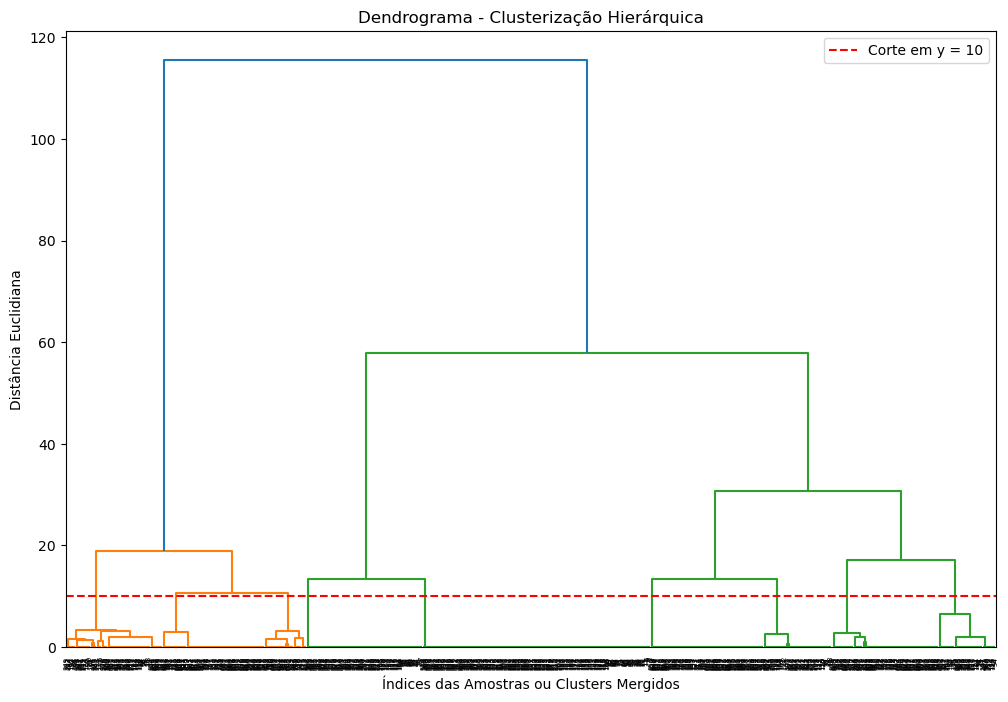

In [63]:
plotDendogram(X_titanic, numberClusters, methodClusters)

In [64]:

plotClusters(X_titanic, labels)

In [65]:
calculateSilhouette(X_titanic, labels)

Coeficiente médio de silhueta (Geral): 0.904

Coeficiente médio de silhueta por cluster:
Cluster
0    0.727
1    0.873
2    0.648
3    0.835
4    1.000
5    0.834
6    0.845
7    1.000
8    1.000
9    1.000
Name: Silhouette, dtype: float64


In [66]:
calculateClusteringMetrics(X_titanic, labels)

{'Davies-Bouldin Index': 0.25, 'Calinski-Harabasz Index': 21891.25}

## Etapa 6: Análise dos Clusters

In [67]:
# region Mapeamentos das variáveis mais Influentes
# Mapeamento
classMapping = {1: "Classe A", 2: "Classe B", 3: "Classe C"}
sexMapping = {0: "Feminino", 1: "Masculino"}
ageMapping = {0: "Adultos (18-50)", 1: "Idosos (50+)", 2: "Jovens (0-17)"}
embarkedMapping = {1: "Cherbourg", 2: "Queenstown", 3: "Southampton"}

data = titanic.copy()
data["Cluster"] = labels

# Aplicação do Mapeamento
data["Pclass"] = data["Pclass"].map(classMapping)
data["Sex"] = data["Sex"].map(sexMapping)
data["AgeGroup"] = data["AgeGroup"].map(ageMapping)
data["Embarked"] = data["Embarked"].map(embarkedMapping)
# endregion

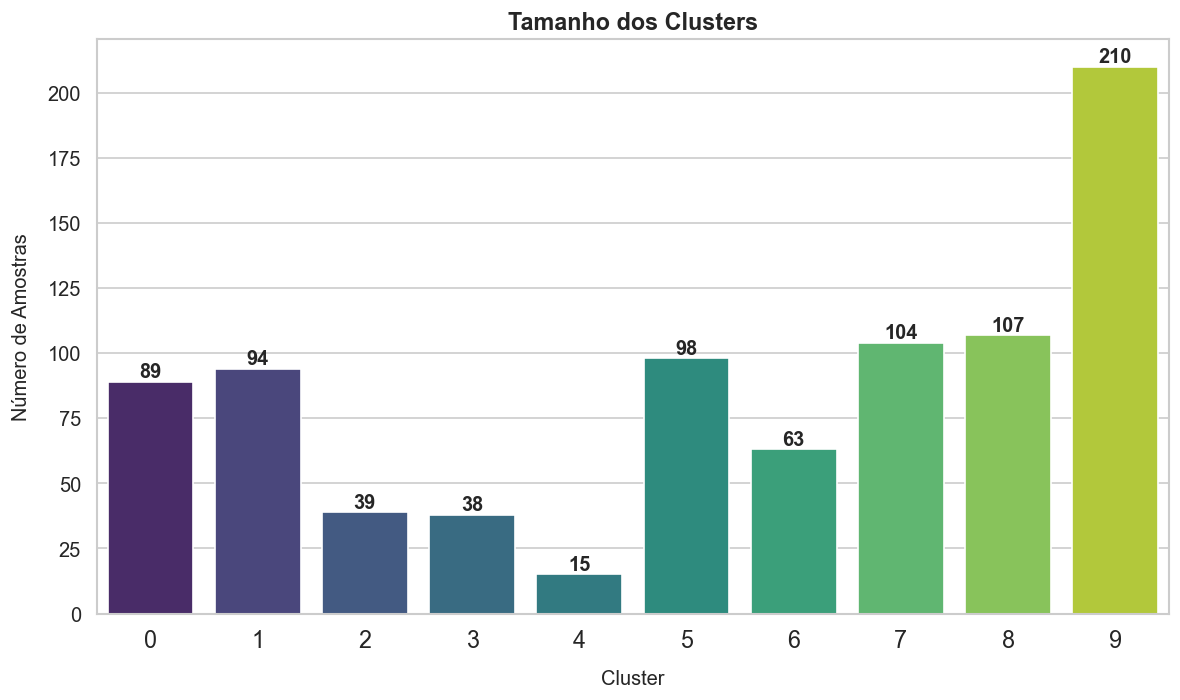

In [68]:
# region Taamanho de Amostras por Clusters
clusterSizes = pd.Series(labels).value_counts()

# Estilo do seaborn para o gráfico
sns.set_theme(style="whitegrid")

# Criação do gráfico com formatação elegante
plt.figure(figsize=(10, 6), dpi=120)
ax = sns.barplot(x=clusterSizes.index, y=clusterSizes.values, palette="viridis")

# Configurações adicionais para tornar o gráfico mais elegante
ax.set_title("Tamanho dos Clusters", fontsize=14, weight="bold")
ax.set_xlabel("Cluster", fontsize=12, labelpad=10)
ax.set_ylabel("Número de Amostras", fontsize=12, labelpad=10)

for container in ax.containers:
    ax.bar_label(container, fmt="%d", label_type="edge", fontsize=12, weight="bold")

plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()
# endregion

In [69]:
topInfluences

Cluster,0,1,2,3,4,5,6,7,8,9
Pclass,0.843,0.000,0.603,0.842,0.000,0.041,0.000,0.500,0.500,1.000
Sex,1.000,0.000,0.000,1.000,1.000,0.000,1.000,0.000,1.000,1.000
AgeGroup,0.843,0.117,0.897,0.000,0.500,0.102,0.167,0.000,0.000,0.000
Embarked,0.888,1.000,0.782,0.000,0.000,0.010,0.992,1.000,1.000,1.000


### Cluster 0

In [70]:
# region Cluster 0
cluster = 0
cols = getInfluentialVariables(topInfluences.data, cluster)
grouped = translateFields(cols)

filterByCluster(data=data, cluster=cluster, cols=cols, grouped=grouped)
#endregion

,Sexo,Porto,Classe,Total,Sobreviventes
0,Masculino,Cherbourg,Classe C,5,0
1,Masculino,Queenstown,Classe B,3,0
2,Masculino,Queenstown,Classe C,7,0
3,Masculino,Southampton,Classe B,25,11
4,Masculino,Southampton,Classe C,49,0


### Cluster 1

In [71]:
# region Cluster 1
cluster = 1
cols = getInfluentialVariables(topInfluences.data, cluster)
grouped = translateFields(cols)

filterByCluster(data=data, cluster=cluster, cols=cols, grouped=grouped)
#endregion

,Porto,Grupo de Idade,Classe,Total,Sobreviventes
0,Southampton,Adultos (18-50),Classe A,72,72
1,Southampton,Idosos (50+),Classe A,22,22


### Cluster 2

In [72]:
# region Cluster 2
cluster = 2
cols = getInfluentialVariables(topInfluences.data, cluster)
grouped = translateFields(cols)

filterByCluster(data=data, cluster=cluster, cols=cols, grouped=grouped)
#endregion

,Grupo de Idade,Porto,Classe,Total,Sobreviventes
0,Idosos (50+),Southampton,Classe B,7,7
1,Idosos (50+),Southampton,Classe C,1,1
2,Jovens (0-17),Cherbourg,Classe B,5,5
3,Jovens (0-17),Queenstown,Classe C,7,7
4,Jovens (0-17),Southampton,Classe B,19,19


### Cluster 3

In [73]:
# region Cluster 3
cluster = 3
cols = getInfluentialVariables(topInfluences.data, cluster)
grouped = translateFields(cols)

filterByCluster(data=data, cluster=cluster, cols=cols, grouped=grouped)
#endregion

,Sexo,Classe,Grupo de Idade,Total,Sobreviventes
0,Masculino,Classe B,Adultos (18-50),12,0
1,Masculino,Classe C,Adultos (18-50),26,0


### Cluster 4

In [74]:
# region Cluster 4
cluster = 4
cols = getInfluentialVariables(topInfluences.data, cluster)
grouped = translateFields(cols)

filterByCluster(data=data, cluster=cluster, cols=cols, grouped=grouped)
#endregion

,Sexo,Grupo de Idade,Classe,Total,Sobreviventes
0,Masculino,Idosos (50+),Classe A,15,0


### Cluster 5

In [75]:
# region Cluster 5
cluster = 5
cols = getInfluentialVariables(topInfluences.data, cluster)
grouped = translateFields(cols)

filterByCluster(data=data, cluster=cluster, cols=cols, grouped=grouped)
#endregion

,Grupo de Idade,Classe,Porto,Total,Sobreviventes
0,Adultos (18-50),Classe A,Cherbourg,68,68
1,Adultos (18-50),Classe A,Queenstown,2,2
2,Adultos (18-50),Classe B,Cherbourg,8,8
3,Idosos (50+),Classe A,Cherbourg,20,20


### Cluster 6

In [76]:
# region Cluster 6
cluster = 6
cols = getInfluentialVariables(topInfluences.data, cluster)
grouped = translateFields(cols)

filterByCluster(data=data, cluster=cluster, cols=cols, grouped=grouped)
#endregion

,Sexo,Porto,Grupo de Idade,Total,Sobreviventes
0,Masculino,Queenstown,Adultos (18-50),1,0
1,Masculino,Southampton,Adultos (18-50),41,0
2,Masculino,Southampton,Idosos (50+),21,0


### Cluster 7

In [77]:
# region Cluster 7
cluster = 7
cols = getInfluentialVariables(topInfluences.data, cluster)
grouped = translateFields(cols)

filterByCluster(data=data, cluster=cluster, cols=cols, grouped=grouped)
#endregion

,Porto,Classe,Sexo,Total,Sobreviventes
0,Southampton,Classe B,Feminino,104,104


### Cluster 8

In [78]:
# region Cluster 8
cluster = 8
cols = getInfluentialVariables(topInfluences.data, cluster)
grouped = translateFields(cols)

filterByCluster(data=data, cluster=cluster, cols=cols, grouped=grouped)
#endregion

,Sexo,Porto,Classe,Total,Sobreviventes
0,Masculino,Southampton,Classe B,107,0


### Cluster 9

In [79]:
# region Cluster 9
cluster = 9
cols = getInfluentialVariables(topInfluences.data, cluster)
grouped = translateFields(cols)

filterByCluster(data=data, cluster=cluster, cols=cols, grouped=grouped)
#endregion

,Classe,Sexo,Porto,Total,Sobreviventes
0,Classe C,Masculino,Southampton,210,0


### Outros Resultados

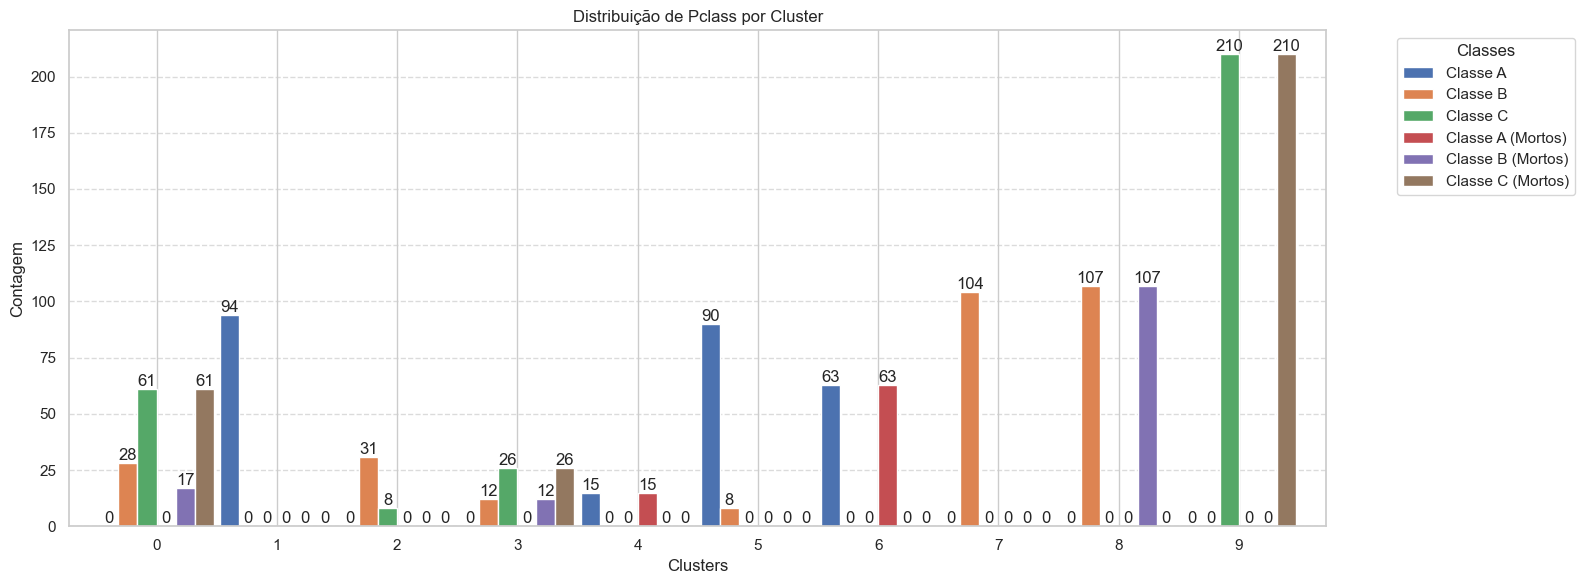

In [80]:
# region Distribuição de "Pclass" por cluster.
classMapping = {1: "Classe A", 2: "Classe B", 3: "Classe C"}

dataClass = X_titanic.copy()
dataClass["Pclass"] = titanic["Pclass"].map(classMapping)
dataClass["Survived"] = titanic["Survived"]

plotBarChartWithDeaths(
    data=dataClass,
    columns=["Cluster", "Pclass"],
    title="Distribuição de Pclass por Cluster",
    xlabel="Clusters",
    ylabel="Contagem",
    legend="Classes",
)
# endregion

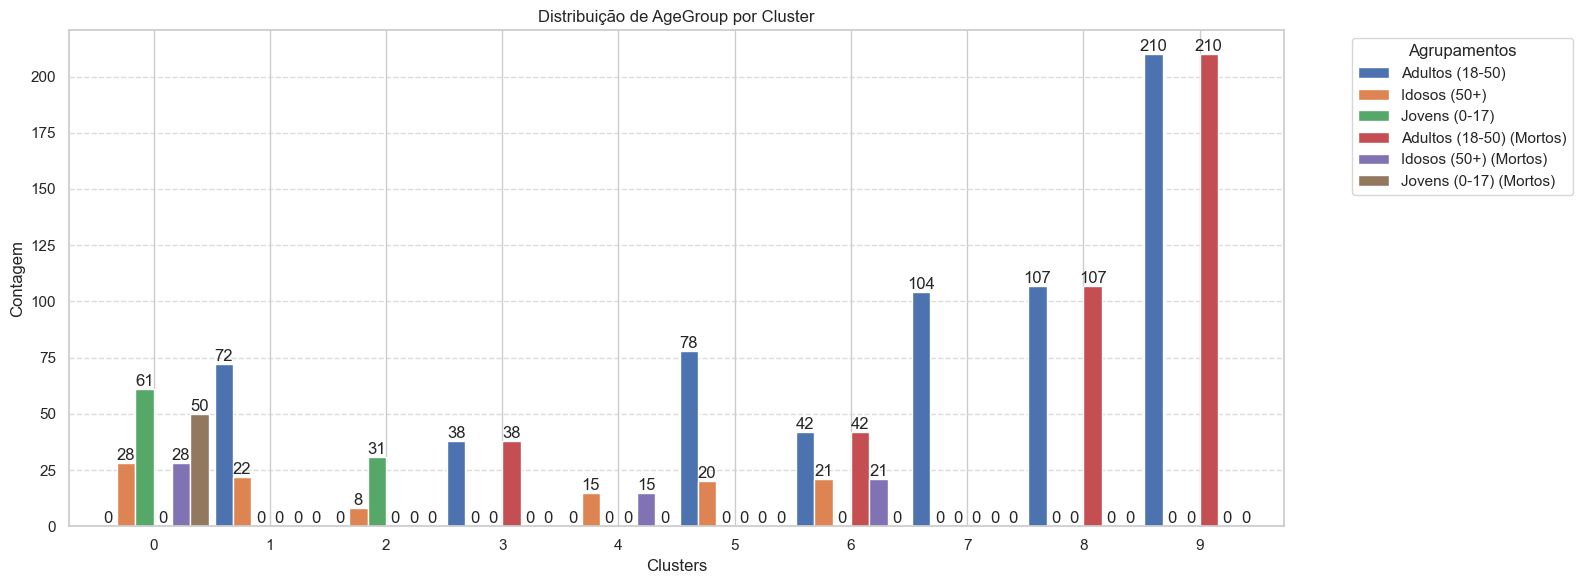

In [81]:
# region Distribuição de "AgeGroup" por cluster.
ageMapping = {0: "Adultos (18-50)", 1: "Idosos (50+)", 2: "Jovens (0-17)"}

dataAge = X_titanic.copy()
dataAge["AgeGroup"] = titanic["AgeGroup"].map(ageMapping)
dataAge["Survived"] = titanic["Survived"]

plotBarChartWithDeaths(
    data=dataAge,
    columns=["Cluster", "AgeGroup"],
    title="Distribuição de AgeGroup por Cluster",
    xlabel="Clusters",
    ylabel="Contagem",
    legend="Agrupamentos",
)
# endregion

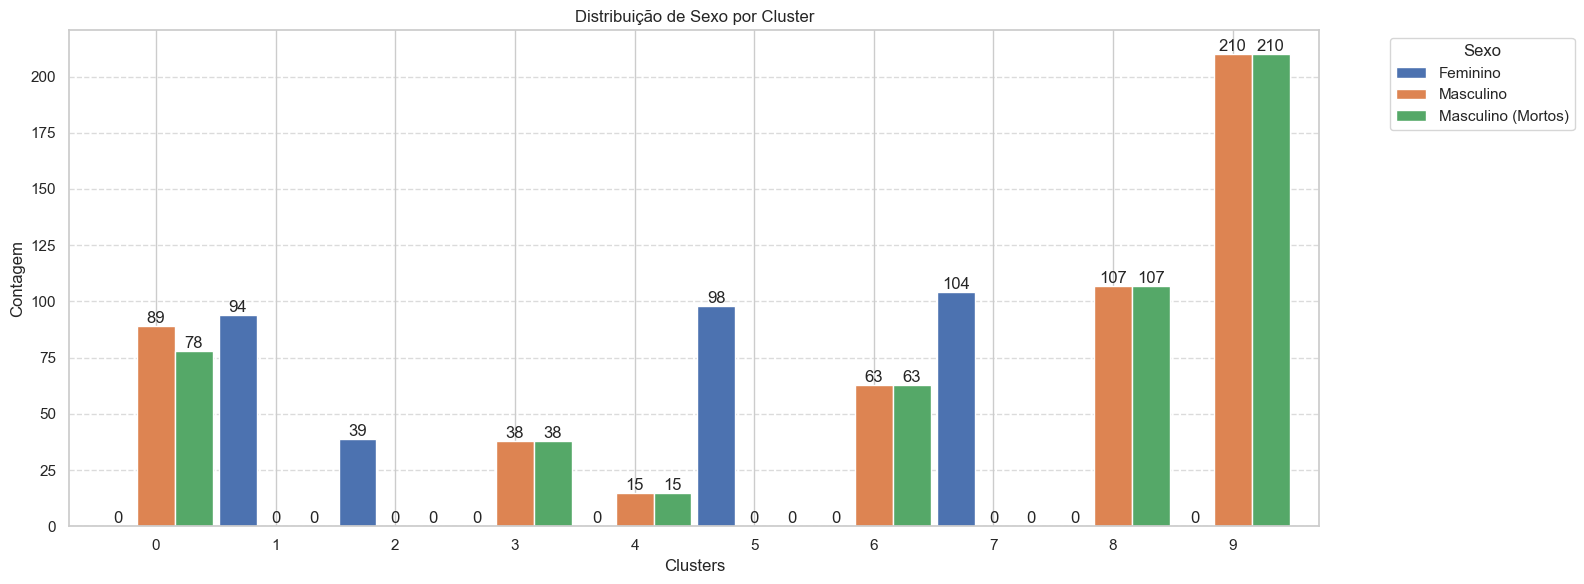

In [82]:
# region Proporção de homens e mulheres em cada cluster.
sexMapping = {0: "Feminino", 1: "Masculino"}

dataSex = X_titanic.copy()
dataSex["Sex"] = titanic["Sex"].map(sexMapping)
dataSex["Survived"] = titanic["Survived"]

plotBarChartWithDeaths(
    data=dataSex,
    columns=["Cluster", "Sex"],
    title="Distribuição de Sexo por Cluster",
    xlabel="Clusters",
    ylabel="Contagem",
    legend="Sexo",
)
# endregion

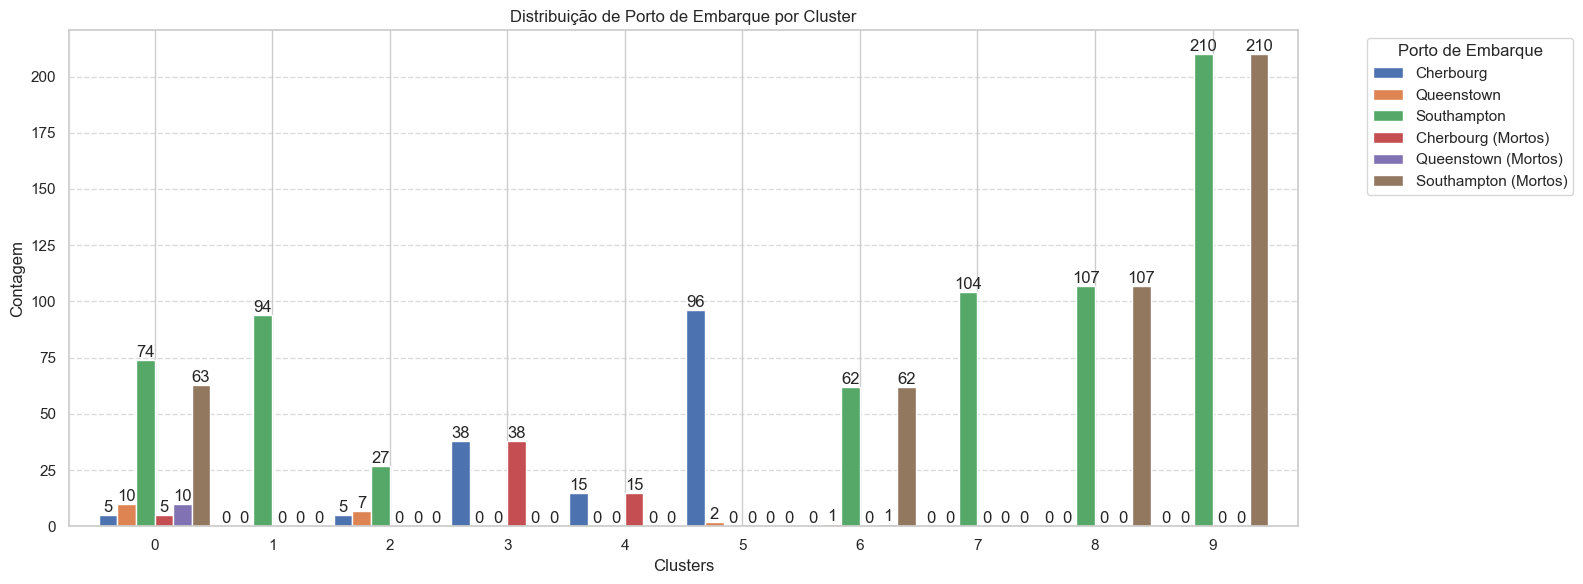

In [83]:
# region Explorar os portos de embarque predominantes em cada cluster.
embarkedMapping = {1: "Cherbourg", 2: "Queenstown", 3: "Southampton"}

dataEmbarked = X_titanic.copy()
dataEmbarked["Embarked"] = titanic["Embarked"].map(embarkedMapping)
dataEmbarked["Survived"] = titanic["Survived"]

plotBarChartWithDeaths(
    data=dataEmbarked,
    columns=["Cluster", "Embarked"],
    title="Distribuição de Porto de Embarque por Cluster",
    xlabel="Clusters",
    ylabel="Contagem",
    legend="Porto de Embarque",
)
# endregion

## **"Nem Deus pode afundar esse navio."**

## **A soberba precede a destruição, e a altivez do espírito precede a queda.** *(Provérbios 16:18)*

<img src="figs/Titanic.JPG" alt="Titanic" width="900"/>